In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import pickle
import os
from scipy import io
from time import time

%matplotlib inline

TRAINING_DATA = "data/digit-dataset/train.mat"
TEST_DATA = "data/digit-dataset/test.mat"
EXP_THRESH = 100.0
GRAD_CHECKING_EPS = 1e-4

np.seterr(divide="raise")

{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
def shuffle_in_unison(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [4]:
training_data = io.loadmat(TRAINING_DATA)
test_data = io.loadmat(TEST_DATA)
train_images = training_data['train_images'].astype(np.float64)
train_labels = np.ones((training_data['train_images'].shape[2], 10)).astype(np.float64) * 0.15
for i in range(training_data['train_images'].shape[2]):
    train_labels[i][training_data['train_labels'][i][0]] = 0.85
train_images = np.rollaxis(train_images, 2, 0)
train_images = train_images.reshape((train_images.shape[0], train_images.shape[1]*train_images.shape[2]))

# normalize data to have mean of 0 and standard deviation of 1
train_mean = np.mean(train_images, axis=0)
train_images = train_images - train_mean
train_std = np.std(train_images, axis=0)
train_std[train_std == 0.0] = 1.0
train_images = train_images / train_std

"""
# normalize data with L2-norm
norm = np.linalg.norm(train_images, axis=0)
norm[norm == 0.0] = 1.0
train_images = train_images / norm
"""

train_images, train_labels = shuffle_in_unison(train_images, train_labels)
test_images = test_data['test_images'].reshape((10000, 784))
test_images = (test_images - train_mean) / train_std

train_images, validation_images = train_images[:50000], train_images[50000:]
train_labels, validation_labels = train_labels[:50000], train_labels[50000:]

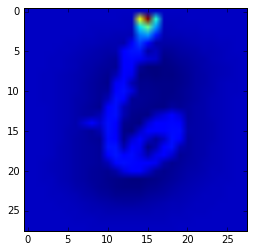

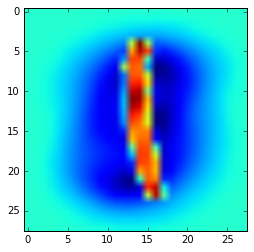

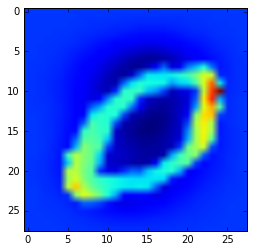

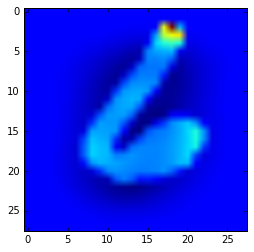

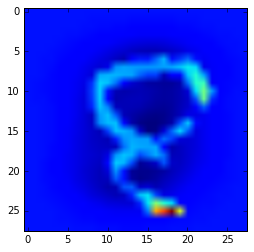

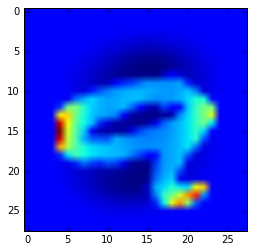

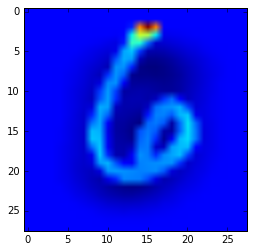

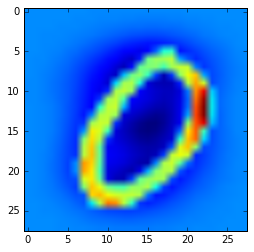

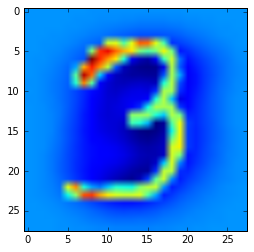

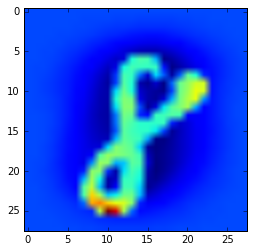

In [390]:
# Display a few training and test data to ensure correct orientations
for i in range(5):
    plt.figure()
    plt.imshow(train_images[i].reshape((28, 28)))
    plt.figure()
    plt.imshow(test_images[i].reshape((28, 28)))

## Neural Network Class

In [47]:
class NeuralNetwork:
    def __init__(self, name, input_layer_size=784, hidden_layer_size=200, \
                 output_layer_size=10, write_freq=10, learning_rate=1e-1, \
                 compute_cost_freq=20, convergence_avg_k=10, convergence_avg_threshold=1e-8, \
                 weight_std=0.01):
        # 1 extra unit in both input and hidden layers
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size
        
        self.V = np.random.randn(self.input_layer_size + 1, \
                                 self.hidden_layer_size) * weight_std
        self.W = np.random.randn(self.hidden_layer_size + 1, \
                                 self.output_layer_size) * weight_std
        
        self.name = name
        self.compute_cost_freq = compute_cost_freq # compute cost every * iterations
        self.write_freq = write_freq # write NN to disk every * iterations
        self.learning_rate = learning_rate # learning rate for gradient descent
        self.convergence_avg_k = convergence_avg_k
        self.convergence_avg_threshold = convergence_avg_threshold
        
    def forward(self, X):
        X = np.hstack((X, np.ones(X.shape[0]).reshape((-1, 1))))
        self.z2 = np.dot(X, self.V)
        self.a2_temp = self.tanh(self.z2)
        self.a2  = np.hstack((self.a2_temp, np.ones(self.a2_temp.shape[0]).reshape((-1, 1))))
        self.z3 = np.dot(self.a2, self.W)
        a3 = self.sigmoid(self.z3)
        return a3
    
    def backprop_mean_sq(self, X, y):
        yhat = self.forward(X)
        
        delta3 = -(y - yhat) * self.sigmoidprime(self.z3)
        dJdw2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W.T)[:,:-1] * (1.0 - self.a2_temp * self.a2_temp)
        dJdw1 = np.dot(np.hstack((X, np.ones(X.shape[0]).reshape((-1, 1)))).T, delta2)
        
        return dJdw1, dJdw2
    
    def backprop_cross_entropy(self, X, y):
        yhat = self.forward(X)
        
        delta3 = ((1 - y) / (1 - yhat) - (y / yhat)) * self.sigmoidprime(self.z3)
        dJdw2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W.T)[:,:-1] * (1.0 - self.a2_temp * self.a2_temp)
        dJdw1 = np.dot(np.hstack((X, np.ones(X.shape[0]).reshape((-1, 1)))).T, delta2)
        
        return dJdw1, dJdw2
    
    def train(self, X, y, is_mean_sq, init=True, validation_images=None, validation_labels=None):
        # remove existing checkpoints
        if init:
            self.training_error, self.validation_accuracy = [], []
            self.dump_number = 0
            self.costs = []
            self.num_iterations = 0
            if os.path.exists("checkpoints-" + self.name):
                for item in os.listdir("checkpoints-" + self.name):
                    os.unlink("checkpoints-" + self.name + "/" + item)
                os.rmdir("checkpoints-" + self.name)

        indexes = np.arange(0, X.shape[0])

        start_time = time()
        while not self.has_converged():
            if self.num_iterations % X.shape[0] == 0:
                np.random.shuffle(indexes)
            index = indexes[self.num_iterations % X.shape[0]]

            dJdw1, dJdw2 = self.backprop_mean_sq(np.array([X[index]]), np.array([y[index]])) if is_mean_sq else \
                           self.backprop_cross_entropy(np.array([X[index]]), np.array([y[index]]))

            self.V -= dJdw1 * self.learning_rate
            self.W -= dJdw2 * self.learning_rate

            if self.num_iterations % self.compute_cost_freq == 0:
                cost = self.cost_function_mean_sq(X, y) if is_mean_sq else self.cost_function_cross_entropy(X, y)
                self.costs.append(cost)
                print("Iteration #{} -> Cost: {}".format(self.num_iterations, cost))
                
                if validation_images is not None:
                    train_pred = NN.predict(X)
                    train_pred_labels = np.array([pred[0] for pred in train_pred])
                    validation_pred = NN.predict(validation_images)
                    validation_pred_labels = np.array([pred[0] for pred in validation_pred])
                    
                    self.training_error.append(np.sum(np.argmax(y, axis=1) != train_pred_labels) * 100 / y.shape[0])
                    self.validation_accuracy.append(np.sum(np.argmax(validation_labels, axis=1) == validation_pred_labels) * 100 / validation_labels.shape[0])

            # Write NN state to disk every few iterations
            if self.num_iterations % self.write_freq == 0:
                print("Writing to disk #{}".format(self.dump_number))
                self.write_to_disk()
                self.dump_number += 1

            self.num_iterations += 1
                
        end_time = time()
        print("Time taken: {} seconds".format(end_time - start_time))
        
    def has_converged(self):
        return (len(self.costs) > self.convergence_avg_k and np.abs(np.sum(np.diff(self.costs[-self.convergence_avg_k:])) / self.convergence_avg_k) <= self.convergence_avg_threshold)
                
    def write_to_disk(self):
        if not os.path.exists("checkpoints-" + self.name):
            os.mkdir("checkpoints-" + self.name)
        data = {'V': self.V, \
                'W': self.W, \
                'costs': self.costs, \
                'dump_number': self.dump_number, \
                'num_iterations': self.num_iterations, \
                'training_error': self.training_error, \
                'validation_accuracy': self.validation_accuracy }
        pickle.dump(data, open("checkpoints-" + self.name + "/checkpoint" + str(self.dump_number), "w+b"))
    
    def load_from_disk(self, load_iteration_num=None):
        items = [name for name in os.listdir("checkpoints-" + self.name) if name.startswith('checkpoint')]
        if load_iteration_num is None:
            latest_checkpoint = items[np.argmax(np.array([int(name[10:]) for name in items]), axis=0)]
        else:
            latest_checkpoint = "checkpoint" + int(load_iteration_num)
        index = np.argmax(np.array([int(name[10:]) for name in items if name.startswith('checkpoint')]), axis=0)
        data = pickle.load(open("checkpoints-" + self.name + "/" + latest_checkpoint, "r+b"))
        self.V = data['V']
        self.W = data['W']
        self.costs = data['costs'][:-1]
        self.dump_number = data['dump_number'] + 1
        self.num_iterations = data['num_iterations']
        self.training_error = data['training_error']
        self.validation_accuracy = data['validation_accuracy']

    def predict(self, X):
        yhat = self.forward(X)
        index = np.argmax(yhat, axis=1)
        return list(zip(index, yhat))
    
    # Cost functions
    def cost_function_cross_entropy(self, X, y):
        yhat = self.forward(X)
        return -np.sum(np.log(yhat) * y + np.log(1 - yhat) * (1 - y))
    
    def cost_function_mean_sq(self, X, y):
        yhat = self.forward(X)
        return 0.5 * (np.linalg.norm(yhat - y) ** 2)

    # Activation functions
    def sigmoidprime(self, x):
        sig = self.sigmoid(x)
        return sig * (1.0 - sig)
    
    def tanhprime(self, x):
        return 1.0 - self.tanh(x) ** 2
        
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def tanh(self, x):
        x = np.maximum(np.minimum(x, EXP_THRESH), -EXP_THRESH)
        a = np.exp(x)
        b = np.exp(-x)
        return (a - b) / (a + b)
    
    # Helper functions
    def get_params(self):
        return np.concatenate((np.ravel(self.V), np.ravel(self.W)))
    
    def set_params(self, params):
        self.V = params[:self.hidden_layer_size * (self.input_layer_size + 1)]
        self.V = self.V.reshape((self.input_layer_size + 1, self.hidden_layer_size))
        
        self.W = params[self.hidden_layer_size * (self.input_layer_size + 1):]
        self.W = self.W.reshape((self.hidden_layer_size + 1, self.output_layer_size))
        
    def get_gradients_mean_sq(self, X, y):
        dJdw1, dJdw2 = self.backprop_mean_sq(X, y)
        return np.concatenate((np.ravel(dJdw1), np.ravel(dJdw2)))
    
    def get_gradients_cross_entropy(self, X, y):
        dJdw1, dJdw2 = self.backprop_cross_entropy(X, y)
        return np.concatenate((np.ravel(dJdw1), np.ravel(dJdw2)))
    
    def test_gradient_computation(self, X, y, is_mean_sq):
        params = self.get_params()
        delta = np.zeros(params.shape[0])
        grad = np.zeros(params.shape[0])
        
        for i in range(params.shape[0]):
            delta[i] = GRAD_CHECKING_EPS
            
            self.set_params(params - delta)
            cost_dec = self.cost_function_mean_sq(X, y) if is_mean_sq else self.cost_function_cross_entropy(X, y)

            self.set_params(params + delta)
            cost_inc = self.cost_function_mean_sq(X, y) if is_mean_sq else self.cost_function_cross_entropy(X, y)
            
            grad[i] = (cost_inc - cost_dec) / (2.0 * GRAD_CHECKING_EPS)
            
            delta[i] = 0
            
        self.set_params(params)
        real_grad = self.get_gradients_mean_sq(X, y) if is_mean_sq else self.get_gradients_cross_entropy(X, y)
        
        assert (np.linalg.norm(grad - real_grad) / np.linalg.norm(grad + real_grad)) <= 1e-8

## Training with mean squared loss

In [48]:
try:
    NN = NeuralNetwork("nn_mean_sq", write_freq=10000, learning_rate=1e-1, \
                       compute_cost_freq=1000, convergence_avg_k=10, \
                       convergence_avg_threshold=1e-3, weight_std=0.01)
    NN.train(train_images, train_labels, True, init=True, validation_images=validation_images, validation_labels=validation_labels)
except KeyboardInterrupt:
    pass

Iteration #0 -> Cost: 30529.452959615355
Writing to disk #0
Iteration #1000 -> Cost: 5624.228008978083
Iteration #2000 -> Cost: 4939.735168923695
Iteration #3000 -> Cost: 4839.693630577984
Iteration #4000 -> Cost: 4205.005911170479
Iteration #5000 -> Cost: 4039.8898713496014
Iteration #6000 -> Cost: 3912.85889510228
Iteration #7000 -> Cost: 3866.478573800036
Iteration #8000 -> Cost: 3739.1078948339677
Iteration #9000 -> Cost: 3279.724514932506
Iteration #10000 -> Cost: 3428.739539572896
Writing to disk #1
Iteration #11000 -> Cost: 3339.0569203941045
Iteration #12000 -> Cost: 3137.9330161724847
Iteration #13000 -> Cost: 2995.1505537127546
Iteration #14000 -> Cost: 2979.5608150745334
Iteration #15000 -> Cost: 2801.511156369931
Iteration #16000 -> Cost: 2787.8785313849407
Iteration #17000 -> Cost: 3110.4569052286397
Iteration #18000 -> Cost: 2885.2302569649705
Iteration #19000 -> Cost: 2766.1377529910296
Iteration #20000 -> Cost: 2818.8277236141703
Writing to disk #2
Iteration #21000 -> C

Validation error: 5.99
Training error: 4.556


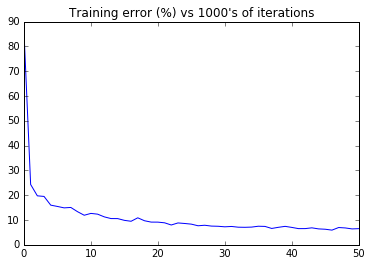

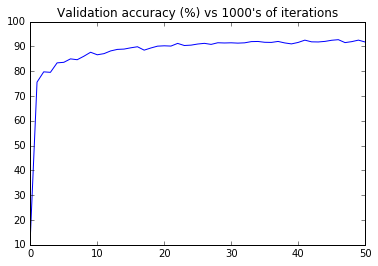

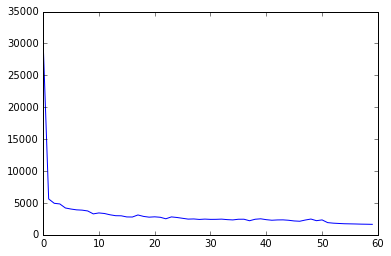

Continue? Y/N N


In [53]:
NN = NeuralNetwork("nn_mean_sq")
NN.load_from_disk()
NN.learning_rate = 0.01
NN.write_freq = 10000
NN.compute_cost_freq = 1000
NN.convergence_avg_threshold = 1e-5
NN.convergence_avg_k = 10

validation_predictions = NN.predict(validation_images)
validation_pred_labels = np.array([pred[0] for pred in validation_predictions])
print("Validation error: {}".format(np.sum(np.argmax(validation_labels, axis=1) != validation_pred_labels) * 100 / validation_labels.shape[0]))

training_predictions = NN.predict(train_images)
training_pred_labels = np.array([pred[0] for pred in training_predictions])
print("Training error: {}".format(np.sum(np.argmax(train_labels, axis=1) != training_pred_labels) * 100 / train_labels.shape[0]))

plt.figure()
plt.title("Training error (%) vs 1000's of iterations")
plt.plot(NN.training_error)
plt.figure()
plt.title("Validation accuracy (%) vs 1000's of iterations")
plt.plot(NN.validation_accuracy)
plt.figure()
plt.plot(NN.costs)
plt.show()

value = input("Continue? Y/N ")
if value == "Y":
    try:
        # NN.train(np.concatenate((train_images, validation_images)), np.concatenate((train_labels, validation_labels)), True, init=False)
        NN.train(train_images, train_labels, True, init=False)
        # NN.train(validation_images, validation_labels, True, init=False)
    except KeyboardInterrupt:
        pass

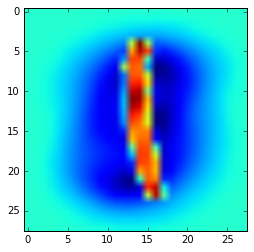

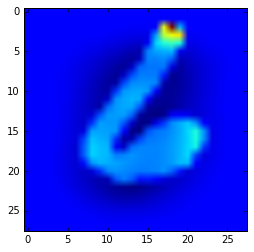

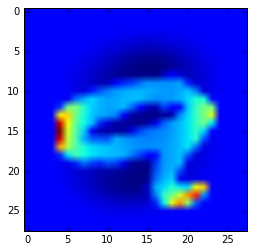

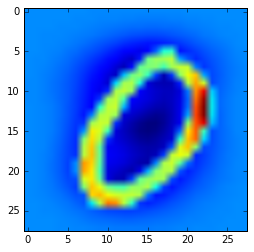

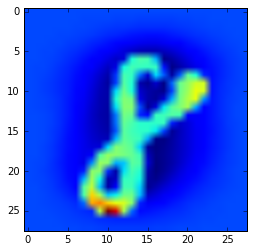

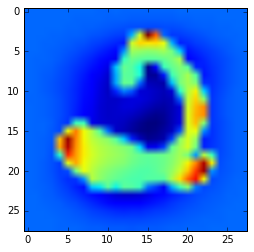

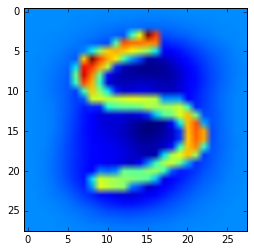

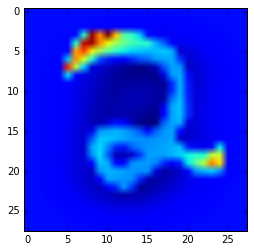

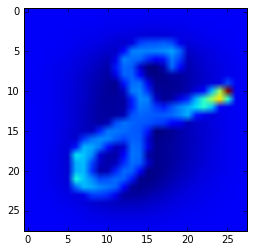

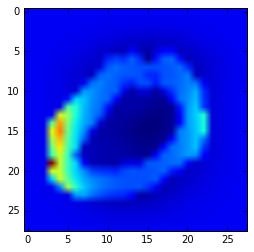

In [519]:
mean_sq_test_predictions = NN.predict(test_images)
mean_sq_test_labels = np.array([pred[0] for pred in mean_sq_test_predictions])
for i in range(10):
    plt.figure()
    plt.imshow(test_images[i].reshape((28, 28)))
with open("mean_sq_predictions.csv", "w+") as f:
    f.write("Id,Category\n")
    for (i, pred) in enumerate(mean_sq_test_labels):
        f.write(str(i+1) + "," + str(pred) + "\n")
    f.close()

## Training with cross entropy loss

In [54]:
try:
    NN = NeuralNetwork("nn_cross_entropy", write_freq=10000, learning_rate=1e-2, \
                       compute_cost_freq=1000, convergence_avg_k=10, \
                       convergence_avg_threshold=1e-3, weight_std=0.01)
    NN.train(train_images, train_labels, False, init=True, validation_images=validation_images, validation_labels=validation_labels)
except KeyboardInterrupt:
    pass

Iteration #0 -> Cost: 345801.64797666436
Writing to disk #0
Iteration #1000 -> Cost: 239520.81848134554
Iteration #2000 -> Cost: 237181.31873482786
Iteration #3000 -> Cost: 235745.18315193825
Iteration #4000 -> Cost: 234379.57943331992
Iteration #5000 -> Cost: 233814.41556278206
Iteration #6000 -> Cost: 232913.9231435242
Iteration #7000 -> Cost: 231576.745325435
Iteration #8000 -> Cost: 231347.38212117983
Iteration #9000 -> Cost: 229483.74232726256
Iteration #10000 -> Cost: 229229.2407609972
Writing to disk #1
Iteration #11000 -> Cost: 228401.58233273803
Iteration #12000 -> Cost: 227441.36910014966
Iteration #13000 -> Cost: 227559.5218028342
Iteration #14000 -> Cost: 226617.81005555263
Iteration #15000 -> Cost: 225574.94025197078
Iteration #16000 -> Cost: 225191.1117414477
Iteration #17000 -> Cost: 225280.47094205188
Iteration #18000 -> Cost: 224804.18742019433
Iteration #19000 -> Cost: 224270.40544309863
Iteration #20000 -> Cost: 224169.45365499394
Writing to disk #2
Iteration #21000 

Validation error: 6.91
Training error: 5.836


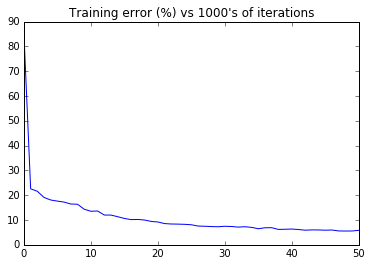

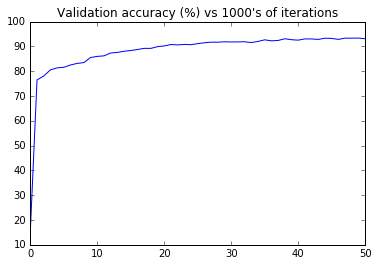

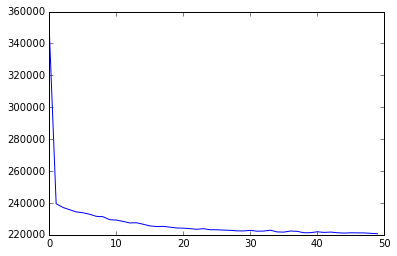

In [ ]:
NN = NeuralNetwork("nn_cross_entropy")
NN.load_from_disk()
NN.learning_rate = 0.00001
NN.write_freq = 10000
NN.compute_cost_freq = 5000
NN.convergence_avg_threshold = 1e-5
NN.convergence_avg_k = 10

validation_predictions = NN.predict(validation_images)
validation_pred_labels = np.array([pred[0] for pred in validation_predictions])
print("Validation error: {}".format(np.sum(np.argmax(validation_labels, axis=1) != validation_pred_labels) * 100 / validation_labels.shape[0]))

training_predictions = NN.predict(train_images)
training_pred_labels = np.array([pred[0] for pred in training_predictions])
print("Training error: {}".format(np.sum(np.argmax(train_labels, axis=1) != training_pred_labels) * 100 / train_labels.shape[0]))

plt.figure()
plt.title("Training error (%) vs 1000's of iterations")
plt.plot(NN.training_error)
plt.figure()
plt.title("Validation accuracy (%) vs 1000's of iterations")
plt.plot(NN.validation_accuracy)
plt.figure()
plt.plot(NN.costs)
plt.show()

value = input("Continue? Y/N ")
if value == "Y":
    try:
        # NN.train(np.concatenate((train_images, validation_images)), np.concatenate((train_labels, validation_labels)), True, init=False)
        NN.train(train_images, train_labels, False, init=False)
        # NN.train(validation_images, validation_labels, False, init=False)
    except KeyboardInterrupt:
        pass

1
6
4
0
8
2
5
2
8
0


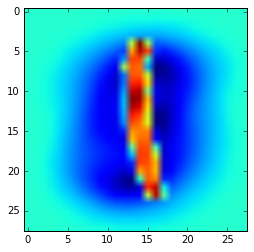

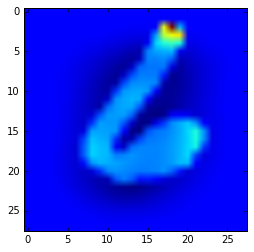

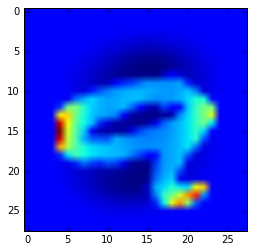

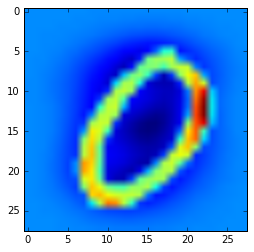

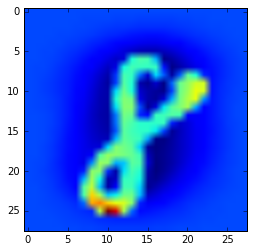

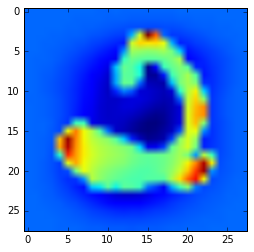

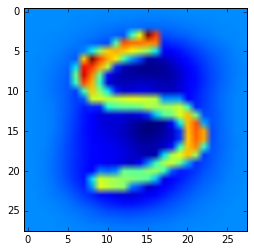

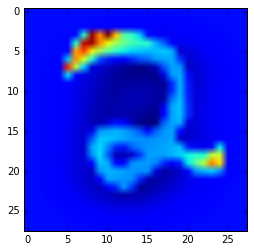

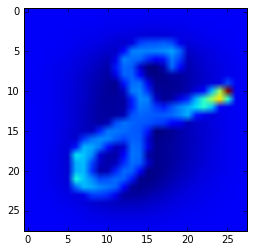

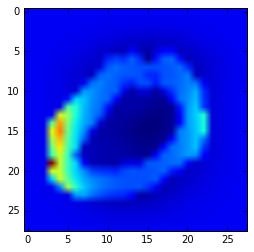

In [42]:
cross_entropy_test_predictions = NN.predict(test_images)
cross_entropy_test_labels = np.array([pred[0] for pred in cross_entropy_test_predictions])
for i in range(10):
    plt.figure()
    print(cross_entropy_test_labels[i])
    plt.imshow(test_images[i].reshape((28, 28)))
with open("cross_entropy_predictions.csv", "w+") as f:
    f.write("Id,Category\n")
    for (i, pred) in enumerate(cross_entropy_test_labels):
        f.write(str(i+1) + "," + str(pred) + "\n")
    f.close()

## Integration and Functionality Tests

In [409]:
# Train XOR function
xorNN = NeuralNetwork("nn_xor", input_layer_size=2, hidden_layer_size=2, output_layer_size=2, \
                      write_freq=10000, learning_rate=1e-1, compute_cost_freq=10000, \
                      convergence_avg_k=5, convergence_avg_threshold=1e-4, weight_std=0.1)
X = np.array([ \
    [0, 0], \
    [0, 1], \
    [1, 0], \
    [1, 1]
])
y = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

n, m = X.shape
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
xorNN.train(X, y, True)
prediction = xorNN.predict(X)
for pred in prediction:
    print(pred)
assert [pred[0] for pred in prediction] == [0, 1, 1, 0]

Iteration #0 -> Cost: 1.0100208537058648
Writing to disk #0
Iteration #10000 -> Cost: 0.010126976464639567
Writing to disk #1
Iteration #20000 -> Cost: 0.003984687212165547
Writing to disk #2
Iteration #30000 -> Cost: 0.002456235381189786
Writing to disk #3
Iteration #40000 -> Cost: 0.0017695332284867866
Writing to disk #4
Iteration #50000 -> Cost: 0.0013808384561713025
Writing to disk #5
Iteration #60000 -> Cost: 0.001131160661828359
Writing to disk #6
Iteration #70000 -> Cost: 0.0009574279503358165
Writing to disk #7
Iteration #80000 -> Cost: 0.0008296513266039433
Writing to disk #8
Iteration #90000 -> Cost: 0.0007317667314111377
Writing to disk #9
Iteration #100000 -> Cost: 0.0006544188370472612
Writing to disk #10
Time taken: 15.642385959625244 seconds
(0, array([ 0.98954065,  0.01045859]))
(1, array([ 0.01476672,  0.98523433]))
(1, array([ 0.01475176,  0.98524929]))
(0, array([ 0.98954068,  0.01045856]))


In [38]:
# Train XOR function
xorNN_mean_sq = NeuralNetwork("nn_xor_mean_sq", input_layer_size=2, hidden_layer_size=2, output_layer_size=2, \
                      write_freq=10000, learning_rate=1e-2, compute_cost_freq=10000, \
                      convergence_avg_k=5, convergence_avg_threshold=1e-4, weight_std=0.5)
X = np.array([ \
    [0, 0], \
    [0, 1], \
    [1, 0], \
    [1, 1]
])
y = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

n, m = X.shape
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
xorNN_mean_sq.train(X, y, True)
prediction = xorNN_mean_sq.predict(X)
for pred in prediction:
    print(pred)
assert [pred[0] for pred in prediction] == [0, 1, 1, 0]

Iteration #0 -> Cost: 1.0011882246776647
Writing to disk #0
Iteration #10000 -> Cost: 0.1729613935790753
Writing to disk #1
Iteration #20000 -> Cost: 0.058912245121503413
Writing to disk #2
Iteration #30000 -> Cost: 0.03348196738046946
Writing to disk #3
Iteration #40000 -> Cost: 0.022985092591855237
Writing to disk #4
Iteration #50000 -> Cost: 0.01736612341128692
Writing to disk #5
Iteration #60000 -> Cost: 0.013897945451894976
Writing to disk #6
Iteration #70000 -> Cost: 0.011555641835432106
Writing to disk #7
Iteration #80000 -> Cost: 0.009872823759205465
Writing to disk #8
Iteration #90000 -> Cost: 0.008608225487121217
Writing to disk #9
Iteration #100000 -> Cost: 0.0076244002640660944
Writing to disk #10
Iteration #110000 -> Cost: 0.006838235559363805
Writing to disk #11
Iteration #120000 -> Cost: 0.006196019700834511
Writing to disk #12
Iteration #130000 -> Cost: 0.005661881307323015
Writing to disk #13
Iteration #140000 -> Cost: 0.00521097425222102
Writing to disk #14
Iteration 

In [40]:
# Train XOR function
xorNN_cross_entropy = NeuralNetwork("nn_xor_cross_entropy", input_layer_size=2, hidden_layer_size=2, output_layer_size=2, \
                      write_freq=10000, learning_rate=1e-1, compute_cost_freq=10000, \
                      convergence_avg_k=5, convergence_avg_threshold=1e-3, weight_std=0.5)
X = np.array([ \
    [0, 0], \
    [0, 1], \
    [1, 0], \
    [1, 1]
])
y = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

n, m = X.shape
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
xorNN_cross_entropy.train(X, y, False)
prediction = xorNN_cross_entropy.predict(X)
for pred in prediction:
    print(pred)
assert [pred[0] for pred in prediction] == [0, 1, 1, 0]

Iteration #0 -> Cost: 5.767474696355198
Writing to disk #0
Iteration #10000 -> Cost: 0.02471733627402896
Writing to disk #1
Iteration #20000 -> Cost: 0.01219652631792238
Writing to disk #2
Iteration #30000 -> Cost: 0.008092529788353895
Writing to disk #3
Iteration #40000 -> Cost: 0.0060544318839143504
Writing to disk #4
Iteration #50000 -> Cost: 0.004836059719963114
Writing to disk #5
Iteration #60000 -> Cost: 0.004025781387537343
Writing to disk #6
Iteration #70000 -> Cost: 0.003447965841921131
Writing to disk #7
Time taken: 10.648031949996948 seconds
(0, array([  9.99426292e-01,   5.74281454e-04]))
(1, array([  2.87772724e-04,   9.99711937e-01]))
(1, array([  2.87772690e-04,   9.99711937e-01]))
(0, array([  9.99426546e-01,   5.74026549e-04]))


In [28]:
sampleNN_mean_sq = NeuralNetwork("nn_sample_mean_sq", input_layer_size=2, hidden_layer_size=3, output_layer_size=1, \
                      write_freq=1e6, learning_rate=1e-2, compute_cost_freq=10000, \
                      convergence_avg_k=5, convergence_avg_threshold=1e-3, weight_std=0.1)
X = np.array([ \
    [4, 6], \
    [7, 2], \
    [8, 5], \
    [3, 7]
]).astype(np.float64)
y = np.array([[85], [50], [95], [70]]).astype(np.float64)

n, m = X.shape
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = y / 100
sampleNN_mean_sq.test_gradient_computation(X, y, True)
try:
    sampleNN_mean_sq.train(X, y, True)
except KeyboardInterrupt:
    pass
prediction = sampleNN_mean_sq.predict(X)
for pred in prediction:
    print(pred)

Iteration #0 -> Cost: 0.17452798695569843
Writing to disk #0
Iteration #10000 -> Cost: 0.05368535368433013
Iteration #20000 -> Cost: 0.023244711595342533
Iteration #30000 -> Cost: 0.011052909108982654
Iteration #40000 -> Cost: 0.008587252609882507
Iteration #50000 -> Cost: 0.0077140499743024345
Iteration #60000 -> Cost: 0.007256325849576745
Iteration #70000 -> Cost: 0.006957599004325568
Time taken: 9.746567964553833 seconds
(0, array([ 0.76024796]))
(0, array([ 0.51505152]))
(0, array([ 0.94388672]))
(0, array([ 0.7748054]))


In [27]:
sampleNN_cross_entropy = NeuralNetwork("nn_sample_cross_entropy", input_layer_size=2, hidden_layer_size=3, output_layer_size=1, \
                      write_freq=1e6, learning_rate=1e-1, compute_cost_freq=10000, \
                      convergence_avg_k=5, convergence_avg_threshold=1e-3, weight_std=0.1)
X = np.array([ \
    [4, 6], \
    [7, 2], \
    [8, 5], \
    [3, 7]
]).astype(np.float64)
y = np.array([[85], [50], [95], [70]]).astype(np.float64)

n, m = X.shape
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = y / 100
sampleNN_cross_entropy.test_gradient_computation(X, y, False)
try:
    sampleNN_cross_entropy.train(X, y, False)
except KeyboardInterrupt:
    pass
prediction = sampleNN_cross_entropy.predict(X)
for pred in prediction:
    print(pred)

Iteration #0 -> Cost: 2.742060964332265
Writing to disk #0
Iteration #10000 -> Cost: 1.925236504018653
Iteration #20000 -> Cost: 1.9252358137667043
Iteration #30000 -> Cost: 1.9252358137667023
Iteration #40000 -> Cost: 1.9252358137667023
Iteration #50000 -> Cost: 1.9252358137667023
Time taken: 6.858320951461792 seconds
(0, array([ 0.85]))
(0, array([ 0.5]))
(0, array([ 0.95]))
(0, array([ 0.7]))


## Answers
- Learning rate: initially 0.1, gradually decreasing by a factor of 10 every few epochs.  
- Weights were initialized with a gaussian distribution of mean 0 and variance 0.1
- Covergence was when the loss function was relatively stable, changing only by about 0.001 in 10000 iterations.
- Training accuracy: 0.99%, Validation accuracy: 0.41% for mean-squared loss
- Training accuracy: 1.41%, Validation accuracy: 1.98% for cross-entropy loss
- Running-time: around 1 hour each
- Kaggle score is 0.96960, using cross-entropy loss.

Using the cross entropy loss function resulted in a much faster convergence with a better performance compared to the mean squared error.
Plots for training error and validation accuracy can be seen above.